# Sentiment Analysis with Deep Learning using BERT

## Exploratory Data Analysis and Preprocessing

In [1]:
!pip install transformers -q
!pip install kagglehub -q
!pip install torch -q


In [2]:
import torch
import pandas as pd
from tqdm.notebook import tqdm
import kagglehub
import os
import boto3
import random

from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification
from sklearn.metrics import accuracy_score
import numpy as np

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [3]:
target = "./Data"
os.makedirs(target, exist_ok=True)
#path = kagglehub.dataset_download("ashkhagan/smile-twitter-emotion-dataset",path=target)

In [4]:
bucket_name = "CwtBertGeneralClassifier"
s3_object_key = "dataset.csv"  # Replace with the key for the file you want to download

#local_file_path = os.path.join(target, "dataset.csv")
#s3.download_file(bucket_name, s3_object_key, local_file_path)

df = pd.read_csv('Data/twitter-sentiment.csv', names=['id', 'text', 'category'])
df.set_index('id', inplace=True)

In [5]:
df.head()

,text,category
id,,
611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
614877582664835073,@Sofabsports thank you for following me back. ...,happy
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


In [6]:
df.text.iloc[0]

'@aandraous @britishmuseum @AndrewsAntonio Merci pour le partage! @openwinemap'

In [7]:
df.category.value_counts()

nocode               1572
happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|disgust             2
sad|angry               2
sad|disgust|angry       1
Name: category, dtype: int64

In [8]:
df = df[~df.category.str.contains('\|')]

In [9]:
df = df[df.category != 'nocode']
df = df[df.category != 'disgust']
df = df[df.category != 'surprise']
df = df[df.category != 'sad']

In [10]:
df.category.value_counts()

happy           1137
not-relevant     214
angry             57
Name: category, dtype: int64

In [11]:
possible_labels = df.category.unique()

In [12]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [13]:
label_dict

{'happy': 0, 'not-relevant': 1, 'angry': 2}

In [14]:
df['label'] = df.category.replace(label_dict)
df.head(5)

,text,category,label
id,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0


## Prepare the training/validation split

In [15]:
TOTAL_EPOCHS = 1
TEST_SIZE = 0.10
RANDOM_STATE = 20
LEARNING_RATE = 1e-5
EPSILON = 1e-8
TRAINING_BATCH_SIZE = 4
LOADER_BATCH_SIZE = 12

In [16]:
x_train, x_val, y_train, y_val = train_test_split(
    df.index.values,
    df.label.values,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=df.label.values
)

In [17]:
df['data_type'] = ['not_set']*df.shape[0]

In [18]:
df.shape[0]

1408

In [19]:
df.head()

,text,category,label,data_type
id,,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0,not_set
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0,not_set
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0,not_set
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0,not_set
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0,not_set


In [20]:
df.loc[x_train,'data_type'] = 'train'
df.loc[x_val, 'data_type'] = 'val'

In [21]:
df.groupby(['category','label', 'data_type']).count()

text
category     label data_type      
angry        2     train        51
                   val           6
happy        0     train      1023
                   val         114
not-relevant 1     train       193
                   val          21

## Loading Tokenizer and Encoding our Data

In [22]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
 )

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [23]:
encode_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encode_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

input_ids_train = encode_data_train['input_ids']
attention_masks_train = encode_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encode_data_val['input_ids']
attention_masks_val = encode_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [24]:
dataset_train = TensorDataset(
    input_ids_train, 
    attention_masks_train, 
    labels_train)

dataset_val = TensorDataset(
    input_ids_val,
    attention_masks_val,
    labels_val)

In [25]:
len(dataset_train)

1267

In [26]:
len(dataset_val)

141

## Setting up BERT Pretrained Model

In [27]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = len(label_dict),
    output_attentions = False,
    output_hidden_states=False
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Creating Data Loaders

In [28]:
dataloader_train = DataLoader (
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=TRAINING_BATCH_SIZE
)

dataloader_val = DataLoader (
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=LOADER_BATCH_SIZE
)
    

## Setting Up Optimizer and Scheduler

In [29]:
optimizer = AdamW (
    model.parameters(),
    lr=LEARNING_RATE, #2e-5 > 5e-5
    eps=EPSILON
)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [30]:
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) * TOTAL_EPOCHS
)

## Performance Metrics

Accuracy metric approach originally used in accuracy function in [this tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification).

In [31]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [32]:
def accuracy_func(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return accuracy_score(labels_flat, preds_flat)

In [33]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        
    

## Clean up DATA folders

In [34]:
import os
import shutil

# Define the path to the Data folder
data_folder = 'Models'

# Check if the folder exists
if os.path.exists(data_folder):
    # Delete all contents within the folder
    for filename in os.listdir(data_folder):
        file_path = os.path.join(data_folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove file or symbolic link
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove directory and its contents
        except Exception as e:
            print(f'Failed to delete {file_path}. Reason: {e}')
else:
    print(f"The folder {data_folder} does not exist.")


## Training Loop

Based on HuggingFace's `run_glue.py` script [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128).

In [35]:
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)


cuda


In [37]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    return loss_val_avg, predictions, true_vals


In [38]:
for epoch in tqdm(range(1, TOTAL_EPOCHS+1)):
    
    model.train()
    loss_train_total = 0
    
    progress_bar = tqdm(
        dataloader_train, 
        desc='Epoch {:1d}'.format(epoch), 
        leave=False,
        disable=False
    )
    
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids'      : batch[0],
            'attention_mask' : batch[1],
            'labels'         : batch[2]
        }
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
                                  
    torch.save(model.state_dict(), f'Models/BERT_ft_epoch{epoch}.model')
    torch.save(model.state_dict(), './model/model.pth') # save latest
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    tokenizer.save_pretrained('./model')

    tqdm.write('\nEpoch {epoch}')
    loss_train_avg = loss_train_total / len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')
    
                                  
                                  

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/317 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: 0.5648538982525044


  0%|          | 0/12 [00:00<?, ?it/s]

Validation loss: 0.5949536350866159
F1 Score (weighted): 0.7392893586560867


In [39]:
import subprocess

# Define paths
model_dir = "model"
tar_name = "bert-ft-model.tar.gz"
token_dir = tokenizer

# Execute the tar command
subprocess.run(["tar", "-czvf", tar_name, "-C", model_dir, "."], check=True)

print(f"{tar_name} has been created successfully.")

./
./special_tokens_map.json
./model.pth
./vocab.txt
./tokenizer_config.json
bert-ft-model.tar.gz has been created successfully.


## Loading and Evaluating of the Model

In [40]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
model.to(device)
pass

In [42]:
model.load_state_dict(
    torch.load(
        'Models/BERT_ft_epoch1.model',
        map_location=torch.device('cpu')
    )
)

_, predictions, true_vals = evaluate(dataloader_val)
accuracy_per_class(predictions, true_vals)

print(f'F1 Score {f1_score_func(predictions, true_vals)}')
print(f'Accuracy {accuracy_func(predictions, true_vals)}')


  0%|          | 0/12 [00:00<?, ?it/s]

Class: happy
Accuracy: 114/114

Class: not-relevant
Accuracy: 1/21

Class: angry
Accuracy: 0/6

F1 Score 0.7392893586560867
Accuracy 0.8156028368794326


Matplotlib is building the font cache; this may take a moment.


  0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1 - F1 Score: 0.7392893586560867, Accuracy: 0.8156028368794326


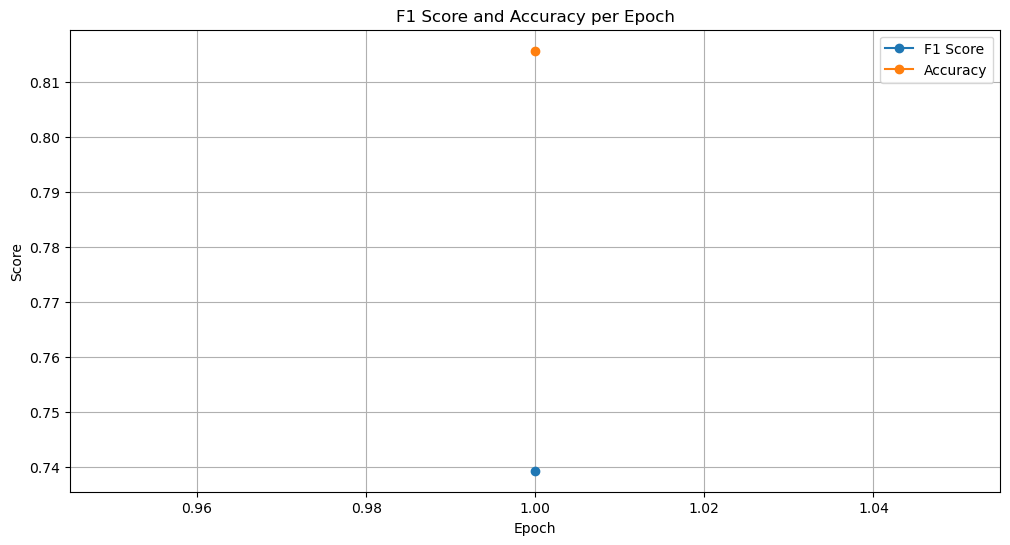

In [43]:
import torch
import matplotlib.pyplot as plt

# Initialize lists to store F1 scores and accuracies for each epoch
f1_scores = []
accuracies = []

# Loop through each epoch, load the model, evaluate, and store metrics
for epoch in range(1, TOTAL_EPOCHS+1):
    # Load model for the current epoch
    model_path = f'Models/BERT_ft_epoch{epoch}.model'
    model.load_state_dict(
        torch.load(model_path, map_location=torch.device('cpu'))
    )
    
    # Evaluate the model on the validation data
    _, predictions, true_vals = evaluate(dataloader_val)
    
    # Calculate F1 score and accuracy
    f1 = f1_score_func(predictions, true_vals)
    accuracy = accuracy_func(predictions, true_vals)
    
    # Append metrics to lists
    f1_scores.append(f1)
    accuracies.append(accuracy)
    
    # Print metrics for each epoch
    print(f'Epoch {epoch} - F1 Score: {f1}, Accuracy: {accuracy}')

# Plot F1 Score and Accuracy across epochs
plt.figure(figsize=(12, 6))

plt.plot(range(1, TOTAL_EPOCHS+1), f1_scores, label='F1 Score', marker='o')
plt.plot(range(1, TOTAL_EPOCHS+1), accuracies, label='Accuracy', marker='o')

# Labeling the plot
plt.title('F1 Score and Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid()

# Display the plot
plt.show()


In [44]:
import sagemaker

# Initialize SageMaker session
sagemaker_session = sagemaker.Session()
bucket = "cwt-bert-classifier"
prefix = "bert-model"
model_name = 'bert-ft-model'
role = 'arn:aws:iam::102854557726:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole'
image = '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference-graviton:2.4.0-cpu-py311-ubuntu22.04-ec2'

sagemaker_session.upload_data(path="bert-ft-model.tar.gz", bucket=bucket)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


's3://cwt-bert-classifier/data/bert-ft-model.tar.gz'

In [61]:
sagemaker_client = boto3.client('sagemaker', region_name='us-east-1')
model_artifact = 's3://' + bucket + '/data/' + 'bert-ft-model.tar.gz'

response = sagemaker_client.create_model(
    ModelName=model_name,
    PrimaryContainer={
        'Image': image,
        'ModelDataUrl': model_artifact
    },
    ExecutionRoleArn = role
)

# Create the endpoint configuration
endpoint_config_name = 'bert-ft-endpoint-config'
sagemaker_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            'VariantName': 'AllTraffic',
            'ModelName': model_name,
            'InstanceType': 'ml.g5.xlarge',
            'InitialInstanceCount': 1
        }
    ]
)

endpoint_name = 'bert-ft-endpoint'
sagemaker_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name
)


{'EndpointArn': 'arn:aws:sagemaker:us-east-1:102854557726:endpoint/bert-ft-endpoint',
 'ResponseMetadata': {'RequestId': '2e4bccf1-469c-4949-9d00-845f74fdbb06',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2e4bccf1-469c-4949-9d00-845f74fdbb06',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '84',
   'date': 'Mon, 18 Nov 2024 18:37:17 GMT'},
  'RetryAttempts': 0}}

In [51]:
import boto3
import json

runtime_client = boto3.client('sagemaker-runtime')

response = runtime_client.invoke_endpoint(
    EndpointName='bert-ft-endpoint',
    ContentType='application/json',
    Body=json.dumps({'text': 'i am really disappointed here.'})
)

result = json.loads(response['Body'].read())
print(result)

ValidationError: An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint bert-ft-endpoint of account 102854557726 not found.

In [62]:
# DELETE ENDPOINT CONFIG NAME
sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

# DELETE MODEL
sagemaker_client.delete_model(ModelName="bert-ft-model")

# DELETE ENDPOINT
sagemaker_client.delete_endpoint(EndpointName=endpoint_name)


ClientError: An error occurred (ValidationException) when calling the DeleteEndpoint operation: Cannot update in-progress endpoint "arn:aws:sagemaker:us-east-1:102854557726:endpoint/bert-ft-endpoint".